In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Function calling with the Gemini API

In [2]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.8 MB/s eta 0:00:00


In [22]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

In [21]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

In [20]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Creating a local Database

In [45]:
%load_ext sql
%sql sqlite:///sample.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [46]:
%%sql

CREATE TABLE IF NOT EXISTS products (
    product_id INTEGER PRIMARY KEY AUTOINCREMENT,
    product_name TEXT NOT NULL,
    price REAL NOT NULL
);

CREATE TABLE IF NOT EXISTS staff (
    staff_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL
);

CREATE TABLE IF NOT EXISTS orders (
    order_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_name TEXT NOT NULL,
    staff_id INTEGER NOT NULL,
    product_id INTEGER NOT NULL,
    FOREIGN KEY (staff_id) REFERENCES staff (staff_id),
    FOREIGN KEY (product_id) REFERENCES products (product_id)
);

INSERT INTO products (product_name, price) VALUES
    ('Laptop', 799.99),
    ('Keyboard', 129.99),
    ('Mouse', 29.99);

INSERT INTO staff (first_name, last_name) VALUES
    ('Alice', 'Smith'),
    ('Bob', 'Johnson'),
    ('Charlie', 'Williams');

INSERT INTO orders (customer_name, staff_id, product_id) VALUES
    ('David Lee', 1, 1),
    ('Emily Chen', 2, 2),
    ('Frank Brown', 1, 3);


   sqlite:///my_database.db
 * sqlite:///sample.db
Done.
Done.
Done.
3 rows affected.
3 rows affected.
3 rows affected.


[]

## Define database functions¶


In [38]:
import sqlite3

db_file = "sample.db"
db_conn = sqlite3.connect(db_file)

In [39]:
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables()')

    cursor = db_conn.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]


list_tables()


 - DB CALL: list_tables()


['products', 'sqlite_sequence']

In [40]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = db_conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]


describe_table("products")

 - DB CALL: describe_table(products)


[('product_id', 'INTEGER'),
 ('product_name', 'VARCHAR(255)'),
 ('price', 'DECIMAL(10, 2)')]

In [48]:
def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    print(f' - DB CALL: execute_query({sql})')

    cursor = db_conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()


execute_query("select * from products")

 - DB CALL: execute_query(select * from products)


[(1, 'Laptop', 799.99), (2, 'Keyboard', 129.99), (3, 'Mouse', 29.99)]

In [42]:
## Implement function calls
db_tools = [list_tables, describe_table, execute_query]

instruction = """You are a helpful chatbot that can interact with an SQL database
for a computer store. You will take the users questions and turn them into SQL
queries using the tools available. Once you have the information you need, you will
answer the user's question using the data returned.

Use list_tables to see what tables are present, describe_table to understand the
schema, and execute_query to issue an SQL SELECT query."""

client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

In [49]:
resp = chat.send_message("What is the cheapest product?")
print(f"\n{resp.text}")

 - DB CALL: execute_query(SELECT product_name, price FROM products ORDER BY price ASC LIMIT 1)

The cheapest product is Mouse, which costs $29.99.


In [50]:
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

response = chat.send_message('What products should salesperson Alice focus on to round out her portfolio? Explain why.')
print(f"\n{response.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(products)
 - DB CALL: describe_table(staff)
 - DB CALL: describe_table(orders)
 - DB CALL: execute_query(SELECT product_name FROM products EXCEPT SELECT T1.product_name FROM products T1 JOIN orders T2 ON T1.product_id = T2.product_id JOIN staff T3 ON T2.staff_id = T3.staff_id WHERE T3.first_name = 'Alice')

Alice should focus on selling Keyboards. This is because she has not sold any keyboards yet, so it would round out her portfolio.



In [51]:
## Inspecting the conversation
import textwrap


def print_chat_turns(chat):
    """Prints out each turn in the chat history, including function calls and responses."""
    for event in chat.get_history():
        print(f"{event.role.capitalize()}:")

        for part in event.parts:
            if txt := part.text:
                print(f'  "{txt}"')
            elif fn := part.function_call:
                args = ", ".join(f"{key}={val}" for key, val in fn.args.items())
                print(f"  Function call: {fn.name}({args})")
            elif resp := part.function_response:
                print("  Function response:")
                print(textwrap.indent(str(resp.response['result']), "    "))

        print()


print_chat_turns(chat)

User:
  "What products should salesperson Alice focus on to round out her portfolio? Explain why."

Model:
  Function call: list_tables()

User:
  Function response:
    ['products', 'sqlite_sequence', 'staff', 'orders']

Model:
  Function call: describe_table(table_name=products)

User:
  Function response:
    [('product_id', 'INTEGER'), ('product_name', 'VARCHAR(255)'), ('price', 'DECIMAL(10, 2)')]

Model:
  Function call: describe_table(table_name=staff)

User:
  Function response:
    [('staff_id', 'INTEGER'), ('first_name', 'TEXT'), ('last_name', 'TEXT')]

Model:
  Function call: describe_table(table_name=orders)

User:
  Function response:
    [('order_id', 'INTEGER'), ('customer_name', 'TEXT'), ('staff_id', 'INTEGER'), ('product_id', 'INTEGER')]

Model:
  Function call: execute_query(sql=SELECT product_name FROM products EXCEPT SELECT T1.product_name FROM products T1 JOIN orders T2 ON T1.product_id = T2.product_id JOIN staff T3 ON T2.staff_id = T3.staff_id WHERE T3.first_name =

## Compositional function calling

In [56]:
from pprint import pformat
from IPython.display import display, Image, Markdown


async def handle_response(stream, tool_impl=None):
  """Stream output and handle any tool calls during the session."""
  all_responses = []

  async for msg in stream.receive():
    all_responses.append(msg)

    if text := msg.text:
      # Output any text chunks that are streamed back.
      if len(all_responses) < 2 or not all_responses[-2].text:
        # Display a header if this is the first text chunk.
        display(Markdown('### Text'))

      print(text, end='')

    elif tool_call := msg.tool_call:
      # Handle tool-call requests.
      for fc in tool_call.function_calls:
        display(Markdown('### Tool call'))

        # Execute the tool and collect the result to return to the model.
        if callable(tool_impl):
          try:
            result = tool_impl(**fc.args)
          except Exception as e:
            result = str(e)
        else:
          result = 'ok'

        tool_response = types.LiveClientToolResponse(
            function_responses=[types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': result},
            )]
        )
        await stream.send(input=tool_response)

    elif msg.server_content and msg.server_content.model_turn:
      # Print any messages showing code the model generated and ran.

      for part in msg.server_content.model_turn.parts:
          if code := part.executable_code:
            display(Markdown(
                f'### Code\n```\n{code.code}\n```'))

          elif result := part.code_execution_result:
            display(Markdown(f'### Result: {result.outcome}\n'
                             f'```\n{pformat(result.output)}\n```'))

          elif img := part.inline_data:
            display(Image(img.data))

  print()
  return all_responses

In [57]:
model = 'gemini-2.0-flash-exp'
live_client = genai.Client(api_key=GOOGLE_API_KEY,
                           http_options=types.HttpOptions(api_version='v1alpha'))

# Wrap the existing execute_query tool you used in the earlier example.
execute_query_tool_def = types.FunctionDeclaration.from_callable(
    client=live_client, callable=execute_query)

# Provide the model with enough information to use the tool, such as describing
# the database so it understands which SQL syntax to use.
sys_int = """You are a database interface. Use the `execute_query` function
to answer the users questions by looking up information in the database,
running any necessary queries and responding to the user.

You need to look up table schema using sqlite3 syntax SQL, then once an
answer is found be sure to tell the user. If the user is requesting an
action, you must also execute the actions.
"""

config = {
    "response_modalities": ["TEXT"],
    "system_instruction": {"parts": [{"text": sys_int}]},
    "tools": [
        {"code_execution": {}},
        {"function_declarations": [execute_query_tool_def.to_json_dict()]},
    ],
}

async with live_client.aio.live.connect(model=model, config=config) as session:

  message = "Please generate and insert 5 new rows in the orders table."
  print(f"> {message}\n")

  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)

> Please generate and insert 5 new rows in the orders table.



### Text

I need to understand the structure of the `orders` table before I can insert new rows. I'll start by querying the database schema.


### Code
```
print(default_api.execute_query(sql="PRAGMA table_info(orders);"))

```

### Tool call

 - DB CALL: execute_query(PRAGMA table_info(orders);)


### Result: OUTCOME_OK
```
("{'result': [[0, 'order_id', 'INTEGER', 0, None, 1], [1, 'customer_name', "
 "'TEXT', 1, None, 0], [2, 'staff_id', 'INTEGER', 1, None, 0], [3, "
 "'product_id', 'INTEGER', 1, None, 0]]}\n")
```

### Text

Okay, the `orders` table has columns `order_id` (INTEGER, primary key), `customer_name` (TEXT, not nullable), `staff_id` (INTEGER, not nullable), and `product_id` (INTEGER, not nullable).  Since `order_id` is the primary key and likely auto-incremented, I will not provide a value for that. I'll now construct the SQL insert statements for 5 new rows, assuming I need to provide sample values for other fields.


### Code
```
sql_statements = [
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('John Doe', 101, 201);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Jane Smith', 102, 202);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Peter Jones', 101, 203);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Mary Brown', 103, 201);",
     "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('David Lee', 102, 204);"
]

for sql in sql_statements:
    print(default_api.execute_query(sql=sql))

```

### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('John Doe', 101, 201);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Jane Smith', 102, 202);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Peter Jones', 101, 203);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Mary Brown', 103, 201);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('David Lee', 102, 204);)


### Result: OUTCOME_OK
```
("{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n")
```

### Text

I have inserted 5 new rows into the `orders` table.



> Can you figure out the number of orders that were made by each of the staff?



### Code
```
sql_query = "SELECT name FROM sqlite_master WHERE type='table';"
print(default_api.execute_query(sql=sql_query))

```

### Tool call

 - DB CALL: execute_query(SELECT name FROM sqlite_master WHERE type='table';)


### Result: OUTCOME_OK
```
"{'result': [['products'], ['sqlite_sequence'], ['staff'], ['orders']]}\n"
```

### Text

Okay, I see the tables available are `products`, `staff`, and `orders`. To figure out the number of orders made by each staff, I'll need to join the `staff` and `orders` tables, probably using a staff ID. Let's inspect the schemas of both tables.


### Code
```
print(default_api.execute_query(sql="PRAGMA table_info(staff);"))
print(default_api.execute_query(sql="PRAGMA table_info(orders);"))

```

### Tool call

 - DB CALL: execute_query(PRAGMA table_info(staff);)


### Tool call

 - DB CALL: execute_query(PRAGMA table_info(orders);)


### Result: OUTCOME_OK
```
("{'result': [[0, 'staff_id', 'INTEGER', 0, None, 1], [1, 'first_name', "
 "'TEXT', 1, None, 0], [2, 'last_name', 'TEXT', 1, None, 0]]}\n"
 "{'result': [[0, 'order_id', 'INTEGER', 0, None, 1], [1, 'customer_name', "
 "'TEXT', 1, None, 0], [2, 'staff_id', 'INTEGER', 1, None, 0], [3, "
 "'product_id', 'INTEGER', 1, None, 0]]}\n")
```

### Text

Okay, it looks like `staff` has `staff_id`, `first_name`, and `last_name`, and `orders` has `order_id`, `customer_name`, `staff_id`, and `product_id`. The `staff_id` column is present in both tables, so I can use this for joining. Now let's construct the query to get the order count per staff member.


### Code
```
sql_query = """
SELECT s.first_name, s.last_name, COUNT(o.order_id) AS order_count
FROM staff s
JOIN orders o ON s.staff_id = o.staff_id
GROUP BY s.staff_id;
"""
print(default_api.execute_query(sql=sql_query))

```

### Tool call

 - DB CALL: execute_query(
SELECT s.first_name, s.last_name, COUNT(o.order_id) AS order_count
FROM staff s
JOIN orders o ON s.staff_id = o.staff_id
GROUP BY s.staff_id;
)


### Result: OUTCOME_OK
```
"{'result': [['Alice', 'Smith', 2], ['Bob', 'Johnson', 1]]}\n"
```

### Text

Okay, the query results show that Alice Smith made 2 orders and Bob Johnson made 1 order.

> Generate and run some code to plot this as a python seaborn chart



### Code
```
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

query_results = {'result': [['Alice', 'Smith', 2], ['Bob', 'Johnson', 1]]}
df = pd.DataFrame(query_results['result'], columns=['first_name', 'last_name', 'order_count'])

df['staff_name'] = df['first_name'] + ' ' + df['last_name']

plt.figure(figsize=(8, 6))
sns.barplot(x='staff_name', y='order_count', data=df)
plt.title('Number of Orders per Staff Member')
plt.xlabel('Staff Member')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

```

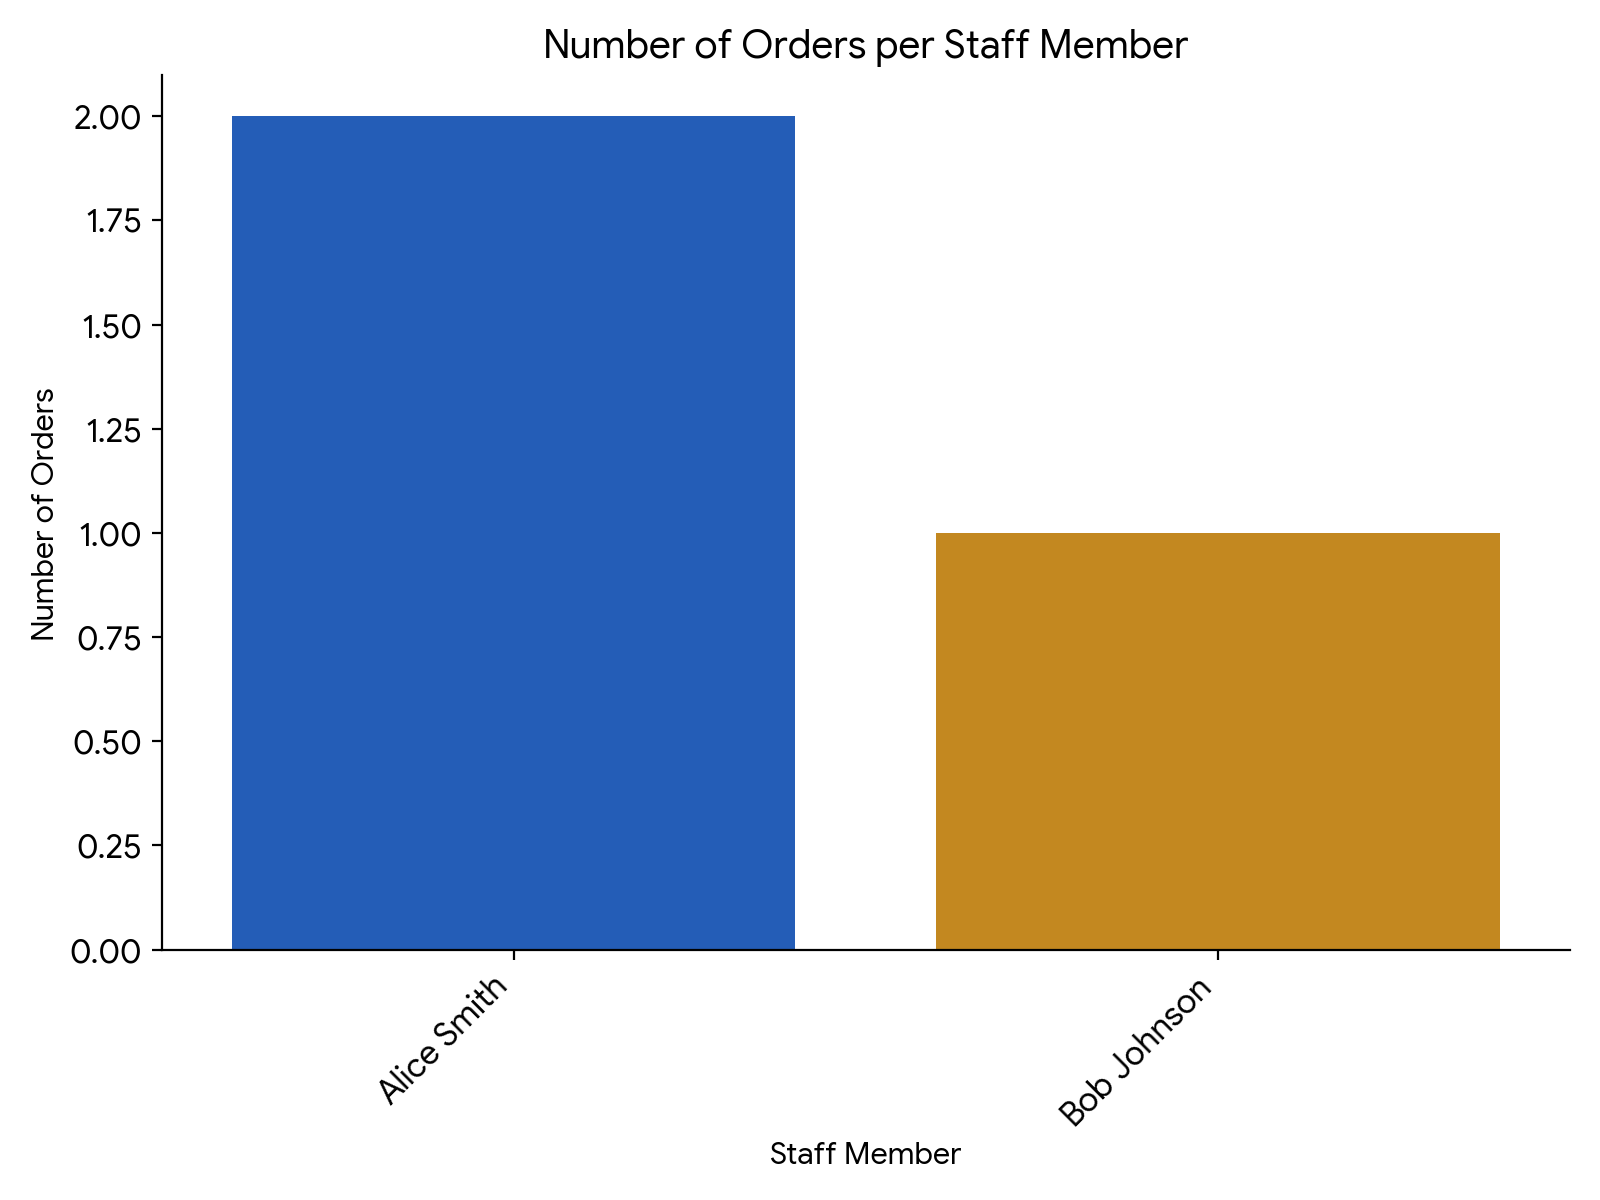

### Text

The bar chart visually represents the number of orders made by each staff member. Alice Smith has made 2 orders, and Bob Johnson has made 1 order.



In [59]:
async with live_client.aio.live.connect(model=model, config=config) as session:

  message = "Can you figure out the number of orders that were made by each of the staff?"

  print(f"> {message}\n")
  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)

  message = "Generate and run some code to plot this as a python seaborn chart"

  print(f"> {message}\n")
  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)

## 2. Building an agent with LangGraph with the gemini api


In [69]:
## setup gemini sdk and langGraph
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [70]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

In [71]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!"
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

In [72]:
## Define a single turn chatbot
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Try using different models. The Gemini 2.0 flash model is highly
# capable, great with tools, and has a generous free tier. If you
# try the older 1.5 models, note that the `pro` models are better at
# complex multi-tool cases like this, but the `flash` models are
# faster and have more free quota.
# Check out the features and quota differences here:
#  - https://ai.google.dev/gemini-api/docs/models/gemini
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

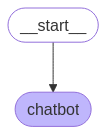

In [73]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [74]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
# pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi there! I'm BaristaBot, ready to take your coffee order. I can tell you about our menu, take your order, and send it to the kitchen. What are you in the mood for today?


In [75]:
user_msg = "Oh great, what kinds of latte can you make?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi there! I'm BaristaBot, ready to take your coffee order. I can tell you about our menu, take your order, and send it to the kitchen. What are you in the mood for today?
HumanMessage: Oh great, what kinds of latte can you make?
AIMessage: We have a few delicious latte options:

*   **Latte:** Our classic espresso and steamed milk.
*   **Mocha Latte:** A chocolatey twist on the classic.
*   **Caramel Latte:** Sweet and smooth with caramel syrup.
*   **Vanilla Latte:** Aromatic and comforting with vanilla syrup.

Would you like to hear more about any of these, or are you ready to order?


In [76]:
## Adding a Human Node
from langchain_core.messages.ai import AIMessage


def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

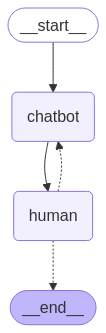

In [77]:
from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [78]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)
config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
# state = chat_with_human_graph.invoke({"messages": []}, config)

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

# pprint(state)

In [80]:
## Add a live menu
from langchain_core.tools import tool


@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but you could connect this to a live stock
    # database, or you could use Gemini's multi-modal capabilities and take live photos of
    # your cafe's chalk menu or the products on the counter and assmble them into an input.

    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate

    Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
  """

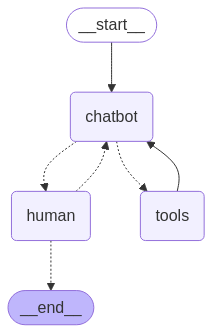

In [81]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(OrderState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [82]:
## Handle Orders
from collections.abc import Iterable
from random import randint

from langchain_core.messages.tool import ToolMessage

# These functions have no body; LangGraph does not allow @tools to update
# the conversation state, so you will implement a separate node to handle
# state updates. Using @tools is still very convenient for defining the tool
# schema, so empty functions have been defined that will be bound to the LLM
# but their implementation is deferred to the order_node.


@tool
def add_to_order(drink: str, modifiers: Iterable[str]) -> str:
    """Adds the specified drink to the customer's order, including any modifiers.

    Returns:
      The updated order in progress.
    """


@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """


@tool
def get_order() -> str:
    """Returns the users order so far. One item per line."""


@tool
def clear_order():
    """Removes all items from the user's order."""


@tool
def place_order() -> int:
    """Sends the order to the barista for fulfillment.

    Returns:
      The estimated number of minutes until the order is ready.
    """


def order_node(state: OrderState) -> OrderState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_order":

            # Each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
            modifiers = tool_call["args"]["modifiers"]
            modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"

            order.append(f'{tool_call["args"]["drink"]} ({modifier_str})')
            response = "\n".join(order)

        elif tool_call["name"] == "confirm_order":

            # We could entrust the LLM to do order confirmation, but it is a good practice to
            # show the user the exact data that comprises their order so that what they confirm
            # precisely matches the order that goes to the kitchen - avoiding hallucination
            # or reality skew.

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.

            print("Your order:")
            if not order:
                print("  (no items)")

            for drink in order:
                print(f"  {drink}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_order":

            response = "\n".join(order) if order else "(no order)"

        elif tool_call["name"] == "clear_order":

            order.clear()
            response = None

        elif tool_call["name"] == "place_order":

            order_text = "\n".join(order)
            print("Sending order to kitchen!")
            print(order_text)

            # TODO(you!): Implement cafe.
            order_placed = True
            response = randint(1, 5)  # ETA in minutes

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}


def maybe_route_to_tools(state: OrderState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"

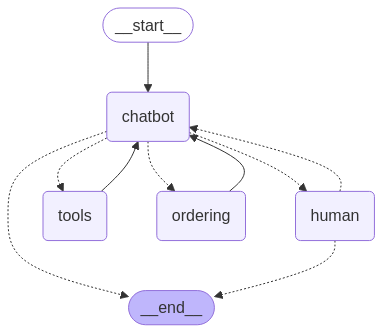

In [83]:
# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# Order-tools will be handled by the order node.
order_tools = [add_to_order, confirm_order, get_order, clear_order, place_order]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(auto_tools + order_tools)


graph_builder = StateGraph(OrderState)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Image(graph_with_order_tools.get_graph().draw_mermaid_png())